# LFD Final
 
Final for the "Learning from Data" course offerd by [Caltech on edX](https://courses.edx.org/courses/course-v1:CaltechX+CS1156x+3T2017). Note that this notebook does not contain *all* solutions; it showcases solutions to those problems that require programming / simulation (and omits pen and paper problems).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import scipy.optimize as opt
from sklearn import svm

%matplotlib notebook

## Regularized Linear Regression (P7 - P10)

First, we are going to load the data. There are two data sets available for this problem

 * [Training Set](http://www.amlbook.com/data/zip/features.train)
 * [Test Set](http://www.amlbook.com/data/zip/features.test)

The data format for each line is: `(digit intensity symmetry)`. Here we can re-use the code for loading data automatically from the last homework:

In [2]:
def load_data(urls=[
        'http://www.amlbook.com/data/zip/features.train',
        'http://www.amlbook.com/data/zip/features.test'
    ]):
    '''Loads the data directly from the AML books website.'''
    
    r = requests.get(urls[0]); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    Y, X = np.split(data,[1], axis=-1)
    
    r = requests.get(urls[1]); r.raise_for_status()
    data = np.loadtxt(r.content.splitlines())
    Y_t, X_t = np.split(data,[1], axis=-1)
    
    return X, Y, X_t, Y_t

In order to make the data available in the following, we run then:

In [3]:
X, Y, X_t, Y_t = load_data()

We will train two types of binary classifiers: *one-versus-one* (ovo), where one digit is class $+1$ and another digit is class $-1$ with the rest of the digits disregarded, and *one-versus-all* (ova), where one digit is $+1$ and the rest of the digits are class $-1$. When evaluating $E_{in}$ and $E_{out}$, we use binary classification error. Implement the regularized least-squares linear regression for classification that minimizes

$$
E_{aug}(\mathbf{w}) = \frac{1}{N}\sum_{n=1}^{N}\left(\mathbf{w}^\intercal\mathbf{z}_n - y_n\right)^2 + \frac{\lambda}{N}\mathbf{w}^\intercal\mathbf{w}
$$

where $\mathbf{w}$ includes $w_0$. This is implemented here in vectorized form, i.e., we minimize

$$
E(\mathbf{w}) = \frac{1}{N}\left(\mathbf{Z}\mathbf{w} - \mathbf{y}\right)^\intercal\left(\mathbf{Z}\mathbf{w} - \mathbf{y}\right) + \frac{\lambda}{N}\mathbf{w}^\intercal\mathbf{w}
$$

using the normal equation or pseudo inverse (least squares) as

$$
\mathbf{w} = \left(\mathbf{Z}^\intercal\mathbf{Z} + \lambda\mathbf{I}\right)^{-1}\mathbf{Z}^\intercal\mathbf{y}
$$

In [4]:
class LRBClassifier:
    ''' Simple linear regression based binary classifier.'''
    
    def __init__(self, X, Y, lambd=0, add_intercept=True):       
        N, d = X.shape
        if add_intercept:
            X, d = np.concatenate((np.ones((N, 1)), X), axis=1), d+1
 
        self.w = np.linalg.pinv(X.T @ X + lambd * np.eye(d)) @ (X.T) @ Y    
        self.E_in = np.sum(self(X, add_intercept=False) != Y)/N
    
    def __call__(self, X, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
        
        return np.sign(X @ self.w).reshape(-1,1)

    def E(self, X, Y, add_intercept=True):
        N, d = X.shape
        if add_intercept:
            X = np.concatenate((np.ones((N, 1)), X), axis=1)
            
        E = np.sum(Y != self(X, add_intercept=False)) / float(N)
        return E

The two multiclass classification approaches outlined above can then be implemented as:

In [5]:
def one_vs_all(label, X, Y, model, kw_params={}):
    ''' Trains one class label against all other class labels using 
    a binary classification model.'''
    
    N, d = X.shape
    Y_prime = (Y == label) * 2. - 1.
    g = model(X, Y_prime, **kw_params)
    return g


def one_vs_one(label, other_label, X, Y, model, kw_params={}):
    ''' Trains one class label agains another using a binary 
    classification model.'''
    
    idx = ((Y == label) | (Y == other_label)).ravel()
    X_prime, Y_prime = X[idx], Y[idx]
    Y_prime = (Y_prime == label) * 2. - 1.
    g = model(X_prime, Y_prime, **kw_params)
    return g

### P7

Set $\lambda=1$ and do not apply a feature transform (i.e., use $\mathbf{z} = \mathbf{x} = \begin{bmatrix}1 & x_1 & x_2\end{bmatrix}^\intercal$). Which among the given classifiers has the lowest $E_{in}$?

In [6]:
G = [one_vs_all(i, X, Y, LRBClassifier, {'lambd': 1.}) for i in range(5, 10)]
E_in = np.array([g.E_in for g in G])

idx = np.argmin(E_in)
print('Minimum E_in\n'+ '-'*12 +'\n[{}] {} versus all'.format(
    'abcde'[idx],
    idx + 5
))

Minimum E_in
------------
[d] 8 versus all


### P8

Now, apply a feature transform $z = (1, x_1, x_2, x_1x_2, x_1^2, x_2^2)$ and set $\lambda = 1$. Which among the following classifiers has the lowest $E_{out}$?

First, we implement the transform $\Phi(X) = Z$ and apply this to our data set for subsequent training in the $\mathcal{Z}$ space:

In [7]:
def Phi(X):
    x1, x2 = np.hsplit(X, 2)
    Z = np.concatenate((X, x1 * x2, x1**2, x2**2), axis=1)
    return Z

Z, Z_t = Phi(X), Phi(X_t)

Now we can perform the experiment as:

In [8]:
G = [one_vs_all(i, Z, Y, LRBClassifier, {'lambd': 1.}) for i in range(5)]
E_out = np.array([g.E(Z_t, (lambda label: (Y_t == label) * 2. - 1.)(i)) for i, g in enumerate(G)])

idx = np.argmin(E_out)
print('Minimum E_out\n'+ '-'*13 +'\n[{}] {} versus all'.format('abcde'[idx], idx))

Minimum E_out
-------------
[b] 1 versus all


### P9

If we compare using the transform versus not using it and apply that to 0-versus-all through 9-versus-all, which of the following statements is correct for $\lambda = 1$?

First, let's train the classifiers under the stated conditions:

In [9]:
G = [one_vs_all(i, X, Y, LRBClassifier, {'lambd': 1.}) for i in range(10)]
G_Phi = [one_vs_all(i, Z, Y, LRBClassifier, {'lambd': 1.}) for i in range(10)]

E_in = np.array([g.E_in for g in G])
E_out = np.array([g.E(X_t, (lambda label: (Y_t == label) * 2. - 1.)(i)) for i, g in enumerate(G)])
E_in_Phi = np.array([g.E_in for g in G_Phi])
E_out_Phi = np.array([g.E(Z_t, (lambda label: (Y_t == label) * 2. - 1.)(i)) for i, g in enumerate(G_Phi)])

Now we plot $E_{in}$ for all classifiers against $E_{out}$ under both conditions:

<IPython.core.display.Javascript object>


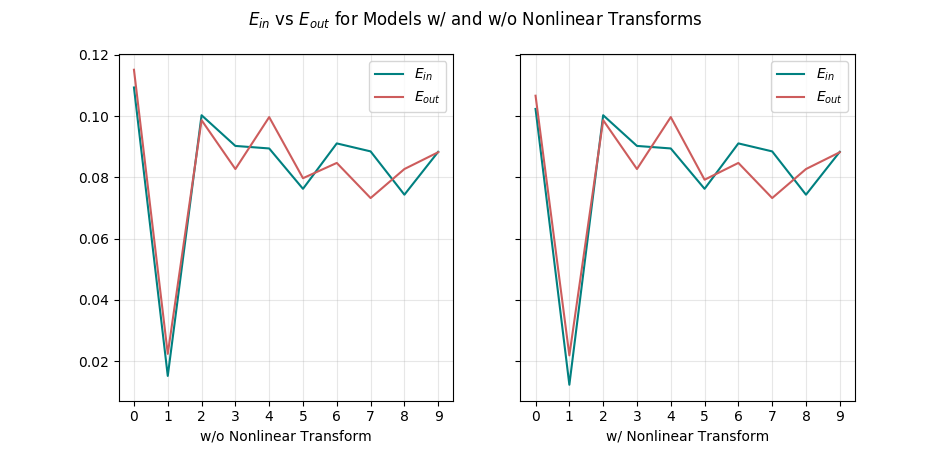

In [10]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(9.5,4.5))
fig.suptitle('$E_{in}$ vs $E_{out}$ for Models w/ and w/o Nonlinear Transforms')

ax[0].plot(range(10), E_in, color='teal', label='$E_{in}$')
ax[0].plot(range(10), E_out, color='indianred', label='$E_{out}$')
ax[0].grid(alpha=.3); ax[0].set_xlabel('w/o Nonlinear Transform'); ax[0].legend();

ax[1].plot(range(10), E_in_Phi, color='teal', label='$E_{in}$')
ax[1].plot(range(10), E_out_Phi, color='indianred', label='$E_{out}$')
ax[1].grid(alpha=.3); ax[1].set_xlabel('w/ Nonlinear Transform'); ax[1].legend();
plt.xticks(np.arange(10));

Here we can clearly see, that using the transform does not seem to cause overfitting, so [a] is clearly not true. But let us test all of the conditions anyway, so we can be sure:

In [11]:
print('Results\n-------\n[a] {}\n[b] {}\n[c] {}\n[d] {}\n[e] {}'.format(
    np.all(E_in_Phi <= E_in) and np.all(E_out_Phi > E_out),
    np.all(E_out_Phi <= .95 * E_out),
    not np.any(E_out_Phi != E_out),
    np.all(E_out_Phi > .95 * E_out),
    (E_out[5] > E_out_Phi[5]) and (E_out[4] - E_out_Phi[4] < .05)
))

Results
-------
[a] False
[b] False
[c] False
[d] False
[e] True


### P10

Train the 1-versus-5 classifier with $z = (1, x_1, x_2, x_1x_2, x_1^2, x_2^2)$ and with $\lambda = 0.01$ and $\lambda = 1$. Which of the following statements is correct?

First, we need a small helper method to gauge $E_{out}$ for the OVO case:

In [12]:
def E_ovo(label, other_label, g, X, Y):
    idx = ((Y == label) | (Y == other_label)).ravel()
    assert np.any(idx)
    
    X_prime, Y_prime = X[idx], Y[idx]
    Y_prime = (Y_prime == label) * 2. - 1.
    return g.E(X_prime, Y_prime)

Now, we can perform the experiment as:

In [13]:
G = [one_vs_one(1, 5, Z, Y, LRBClassifier, {'lambd': lambd}) for lambd in (.01, 1.)]
E_in = np.array([g.E_in for g in G])
E_out = np.array([E_ovo(1, 5, g, Z_t, Y_t) for g in G])

And test for the different conditions as:

In [14]:
print('Results\n-------\n[a] {}\n[b] {}\n[c] {}\n[d] {}\n[e] {}'.format(
    E_in[0] <= E_in[1] and E_out[0] > E_out[1],
    E_in[0] == E_in[1],
    E_out[0] == E_out[1],
    E_in[0] < E_in[1] and E_out[0] < E_out[1],
    E_in[0] > E_in[1] and E_out[0] > E_out[1]
))

Results
-------
[a] True
[b] False
[c] False
[d] False
[e] False


## Support Vector Machines (P12)

Consider the following training set generated from a target function $f: \mathcal{X} \mapsto \{-1, +1\}$ where $\mathcal{X} = \mathbb{R}^2$ and the following data points are given

$$
\begin{array}{rll}
x_1 =& (1, 0)  & y_1 = -1 \\
x_2 =& (0, 1)  & y_2 = -1 \\
x_3 =& (0, -1) & y_3 = -1 \\
x_4 =& (-1, 0) & y_4 = +1 \\
x_5 =& (0, 2)  & y_5 = +1 \\
x_6 =& (0, -2) & y_6 = +1 \\
x_7 =& (-2, 0) & y_7 = +1 \\
\end{array}
$$

In [15]:
X_svm = np.array([[1., 0.], [0., 1.], [0., -1.], [-1., 0.], [0., 2.], [0., -2.], [-2., 0.]])
Y_svm = np.array([[-1.], [-1.], [-1.], [1.], [1.], [1.], [1.]])

### P12

Consider the above training set and apply the hard-margin SVM algorithm with the kernel

$$
K(x, x') = (1 + x^\intercal x')^2
$$

which corresponds to a second-order polynomial transformation. Set up the expression for $\mathcal{L}(\alpha_1, \ldots,\alpha_7)$ and solve for the optimal $\alpha_i$ (numerically, using a quadratic programming package). The number of support vectors you get is in what range?

Let $\mathbf{Q} = \left(\mathbf{Y}\mathbf{Y}^\intercal \odot K(\mathbf{X},\mathbf{X}^\intercal)\right)$ where $K$ is applied elementwise to the two matrices, i.e., the element $K(\mathbf{X},\mathbf{X}^\intercal)_{ij} = K(\mathbf{X}_{ij},\mathbf{X}_{ji})$, then we can use quadratic programming to solve the minimization problem

$$
\begin{array}{rl}
\min_{\alpha} & \mathcal{L}(\alpha) = \frac{1}{2} \alpha^\intercal \mathbf{Q} \alpha + \left(-\mathbf{1}^\intercal\right) \alpha \\
\mathrm{s.t.} & \mathbf{Y}^\intercal\alpha = \mathbf{0} \\
& \mathbf{0} \leq \alpha \leq \infty
\end{array}
$$

For the sake of simplicity, we will not rely on quadratic programming here, but use `scipy`'s [sequential least squares programming (SLSQP)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp) solver instead. Using this solver requires the derivative of $\mathcal{L}(\alpha)$. This can be computed in vectorized form as:

$$
\nabla_{\alpha} \mathcal{L}(\alpha) = \frac{1}{2} \left(\mathbf{Q}^\intercal \mathbf{Q}\right) \alpha - \mathbf{1}
$$

Its implementation is then:

In [16]:
def L(alpha, X, Y):
    Q = (Y @ Y.T) * (1 + X @ X.T)**2
    return 0.5 * alpha.T @ Q @ alpha - np.sum(alpha)
    
    
def nabla_L(alpha, X, Y):
    Q = (Y @ Y.T) * (1 + X @ X.T)**2
    return (0.5 * (Q.T + Q) @ alpha - 1)

And to solve the optimization problem with SLSQP, we can run:

In [17]:
res = opt.minimize(L, np.zeros((7,1)), args=(X_svm, Y_svm), jac=nabla_L, method='SLSQP', 
    constraints=({
        'type': 'eq', 
        'fun': lambda alpha: Y_svm.T @ alpha
    }, {
        'type': 'ineq', 
        'fun': lambda alpha: alpha
    }),
    options={'disp':True, 'ftol': 1e-10}
)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.4074074074073457
            Iterations: 7
            Function evaluations: 9
            Gradient evaluations: 7


The number of support vectors obtained is:

In [18]:
alpha = res.x
print('Result\n------\n#SV = {}'.format(np.sum(np.abs(alpha) > 1e-7)))

Result
------
#SV = 5


## Radial Basis Functions

We experiment with the RBF model, both in regular form (Lloyd + pseudo-inverse) with $K$ centers:

$$
h(x) = \mathrm{sign}\left(\sum_{k = 1}^K w_k \exp(-\gamma \|x - \mu_k\|^2) + b\right)
$$

And in kernel form (using the RBF kernel in hard margin SVMs):

$$
h(x) = \mathrm{sign}\left(\sum_{\alpha_n > 0} \alpha_n y_n \exp(-\gamma \|x - x_n\|^2) + b\right)
$$

The input space is $\mathcal{X} = [-1, 1] \times [-1, 1]$ with uniform probability distribution, and the target function $f$ is:

$$
f(x) = \mathrm{sign}\left(x_2 - x_1 + 0.25 \sin(\pi x_1)\right)
$$

which is slightly nonlinear in the $\mathcal{X}$ space. $f$ can be implemented as:

In [41]:
def f(X):
    return np.sign(X[:,1] - X[:,0] + .25 * np.sin(np.pi * X[:,0])).reshape(-1, 1)

In each run, generate 100 training points at random using this target and apply both forms of RBF to these training points. Here are some guidelines

 * Repeat the experiment for as many runs as needed to get the answer to be stable (statistically away from flipping to the closest competing answer)
 * In case a data set is not separable in the $\mathcal{Z}$ space by the RBF kernel using hard-margin SVM, discard the run, but keep track of how often this happens, if ever.
 * When using Lloyd's algorithm, initialize the centers to random points in $\mathcal{X}$ and iterate until there is no change from iteration to iteration. If a cluster becomes empty, discard the run and repeat

### Models

In order to implement the RBF model, we first need an implementation of Lloyd's algorithm (K-means):

In [20]:
def k_means(K, X):
    '''Simple implementation of Lloyds algorithm to determine a K-means clustering. '''
    
    N, d = X.shape
    idx = np.random.choice(N, K, False)
    Mu, S_, convergence = X[idx].reshape(K, 1, d), np.zeros((N,1)), False
    
    while(not convergence):
        # (i) assign all x to nearest mu_k
        S = np.argmin(np.linalg.norm(X - Mu, axis=2, keepdims=True), axis=0)
        
        # (ii) update mu_k to mean of all x assigned to it
        for k in range(K):
            idx = S.ravel() == k
            if np.any(idx): Mu[k, 0] = np.mean(X[idx], axis=0)
        
        if np.array_equal(S_, S):
            convergence = True
        else:
            S_ = S
            
    return Mu, S

Now we can use this, in order to obtain some cluster centers that will serve as the reference points for the RBF model. Note that in the RBF model, we have to do some pre-processing before we can learn weights / make predictions. Namely, we have to construct the matrix $\Phi$ (c.f., slide 14 in lecture 16). `numpy` allows to construct this matrix fairly efficiently using tensor expressions and broadcasting:

In [23]:
class RBFBClassifier:
    ''' RBF based binary classifier.'''
    
    def __init__(self, X, Y, K=10, gamma=1.5, add_intercept=True):       
        self.Mu, S = k_means(K, X)
        self.empty_clusters = not np.all(np.isin(np.arange(K), S))
        self.gamma, self.K = gamma, K
        
        Phi = self.Phi(X, add_intercept)
        self.w = np.linalg.pinv(Phi.T @ Phi) @ (Phi.T) @ Y      
        self.E_in = self.E(X, Y, add_intercept)
    
    def Phi(self, X, add_intercept):
        N, d = X.shape
        Phi = np.exp(-self.gamma * np.sum((X - self.Mu)**2, axis=-1)).T
        return np.concatenate((np.ones((N, 1)), Phi), axis=1) if add_intercept else Phi

    def E(self, X, Y, add_intercept=True):
        N, d = X.shape     
        E = np.sum(Y != self(X, add_intercept)) / float(N)
        return E
    
    def __call__(self, X, add_intercept=True):
        Phi = self.Phi(X, add_intercept)
        return np.sign(Phi @ self.w).reshape(-1,1)

And the hard margin SVM classifier with RBF kernel is implemented as:

In [24]:
class SVMClassifier:
    '''Soft margin SVM based binary classifier.'''
  
    def __init__(self, X, Y, gamma=1.5, C = np.finfo(float).max):       
        self._h = svm.SVC(
            C = C,
            kernel='rbf',
            gamma=gamma
        ).fit(X, Y.ravel())
        self.E_in = self.E(X, Y)
  
    def __call__(self, X):
        Y_hat = self._h.predict(X).reshape(-1,1)
        return Y_hat
  
    def E(self, X, Y):
        N, d = X.shape
        E = np.sum(Y != self(X)) / float(N)
        return E
    
    def n_sv(self):
        return np.sum(self._h.n_support_)

### Data

Data is generated using $f(x) = \mathrm{sign}\left(x_2 - x_1 + 0.25 \sin(\pi x_1)\right)$. As this is binary classification, we can re-use the code for generating and plotting data given some function $f$ from previous assignments:

In [25]:
def generate_data(N = 10, f=None):
    
    if f is None:
        # choose two random points p1, p2 and compute a vector p orthogonal to their difference
        p1, p2 = (np.random.rand(2,2) - 0.5) * 2.
        p = np.array([1, -(p2 - p1)[0]/(p2 - p1)[1]])
        p /= np.linalg.norm(p)
    
        f = lambda x: np.sign((x - p1) @ p).reshape(-1,1)
        f.db = lambda x: (p2[1] - p1[1])/(p2[0] - p1[0]) * (x - p1[0]) + p1[1]
    
    # generate uniformely distributed data points and apply classifier to label them
    X = (np.random.rand(N, 2) - 0.5) * 2
    Y = f(X)
    
    return X,Y,f


def plot_data(X, Y, db = None, Y_hat = None):
    
    plt.figure()
    
    pos = X[(Y == 1).reshape(-1)]
    neg = X[(Y == -1).reshape(-1)]
    neu = X[(Y == 0).reshape(-1)]
    
    # plot the three groups of examples
    plt.scatter(pos[:,0], pos[:,1], color='teal', marker='+')
    plt.scatter(neg[:,0], neg[:,1], color='indianred', marker='o')
    plt.scatter(neu[:,0], neu[:,1], color='gray', marker='s')
    
    if Y_hat is not None:
        pos_hat = X[(Y_hat == 1).reshape(-1)]
        neg_hat = X[(Y_hat == -1).reshape(-1)]
        neu_hat = X[(Y_hat == 0).reshape(-1)]
        
        plt.scatter(pos_hat[:,0], pos_hat[:,1], color='teal', marker='o', s=100, alpha=.3)
        plt.scatter(neg_hat[:,0], neg_hat[:,1], color='indianred', marker='o', s=100, alpha=.3)
        plt.scatter(neu_hat[:,0], neu_hat[:,1], color='gray', marker='o', s=100, alpha=.3)
    
    
    # plot the decision boundary if provided
    if db is not None:
        x = np.arange(-1., 1., 0.01)
        plt.plot(x, db(x), c='red', ls='dashed', lw=1.)
    
    plt.grid(alpha=.3)
    plt.gca().set_xlim(-1, 1)
    plt.gca().set_ylim(-1, 1)

Given our function $f$ from above, we can now plot some $\mathcal{D}$ generated by $f$ in order to get a feeling for what that function produces. In addition, we will train an RBF model on the data and plot its cluster centers and their predictions:

<IPython.core.display.Javascript object>


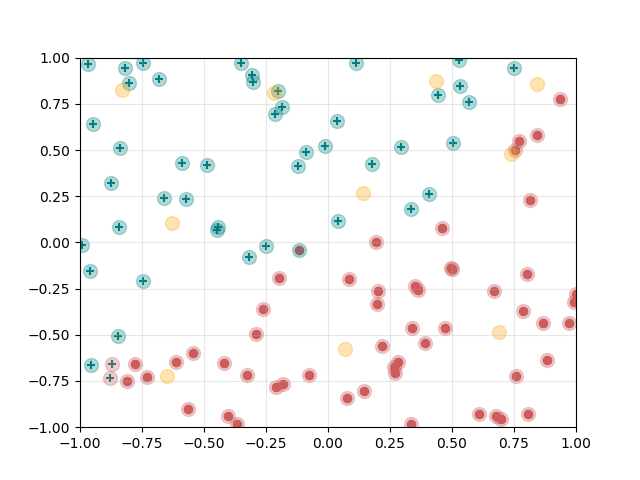

In [46]:
X_rbf, Y_rbf, _ = generate_data(100, f)
g = RBFBClassifier(X_rbf, Y_rbf)
plot_data(X_rbf, Y_rbf, Y_hat=g(X_rbf))
plt.scatter(g.Mu[:,0,0], g.Mu[:,0,1], color='orange', marker='o', s=100, alpha=.3)

As can be seen by the overlay, it works pretty well with a small number of misclassified points.

In [44]:
g.Mu.shape

(10, 1, 2)

### P13

For $\gamma = 1.5$, how often do you get a data set that is not separable by the RBF kernel (using hard-margin SVM)? *Hint: Run the hard-margin SVM, then check if the solution has $E_{in} \neq 0$.*

In [30]:
def experiment_zlinsep(N=100, repeat=1000, f=f, gen=generate_data):
    data = []
    i = 0
    
    while i < repeat:
        # generate test data and function
        X, Y, f = gen(N, f)
        if np.all(np.sign(Y) == -1) or np.all(np.sign(Y) == 1): continue

        # training
        g_svm = SVMClassifier(X, Y, gamma=1.5)
        data.append(g_svm.E_in)
        
        if i%100 == 0:
            print('experiment (run={}):\tE_in={:.3f}'.format(i, g_svm.E_in))

        i += 1
    
    # process and print results
    results = np.array(data)
    print('\nResults\n-------\n{:.2f}% of the time'.format(np.sum(results > 0)/float(repeat)))
    
    return results

Now we can perform the expirement as:

In [31]:
res = experiment_zlinsep()

experiment (run=0):	E_in=0.000
experiment (run=100):	E_in=0.000
experiment (run=200):	E_in=0.000
experiment (run=300):	E_in=0.000
experiment (run=400):	E_in=0.000
experiment (run=500):	E_in=0.000
experiment (run=600):	E_in=0.000
experiment (run=700):	E_in=0.000
experiment (run=800):	E_in=0.000
experiment (run=900):	E_in=0.000

Results
-------
0.00% of the time


### P14

If we use $K=9$ for regular RBF and take $\gamma = 1.5$, how often does the kernel form beat the regular form (excluding runs mentioned in Problem 13 and runs with empty clusters, if any) in terms of $E_{out}$?

First, we setup this experiment and the next:

In [32]:
def experiment_rbf_vs_svm(N=100, N_test=1000, repeat=1000, f=f, gen=generate_data, K=9, gamma=1.5):
    data = []
    i = 0
    
    while i < repeat:
        # generate test data and function
        X, Y, f = gen(N, f)
        if np.all(np.sign(Y) == -1) or np.all(np.sign(Y) == 1): continue

        # training
        g_rbf = RBFBClassifier(X, Y, K=K, gamma=gamma)
        g_svm = SVMClassifier(X, Y, gamma=gamma)
        
        if g_svm.E_in > 0 or g_rbf.empty_clusters: continue

        # obtain the out of sample error rate using the generated function f
        X_test, Y_test, _ = gen(N_test, f)
        E_out = g_rbf.E(X_test, Y_test), g_svm.E(X_test, Y_test)

        # store data
        data.append(E_out)
        
        if i%100 == 0:
            print('experiment (run={}):\tE_out_rbf={:.3f} / E_out_svm={:.3f}'.format(i, *E_out))

        i += 1
    
    # process and print results
    results = np.array(data)
    sep = '-'*7
    print('\nResults\n{}\nE_out_rbf\t= {:.3f}\nE_out_svm\t= {:.3f}\n\nRatio (<)\n{}\nE_out_rbf\t= {:.2f}%\nE_out_svm\t= {:.2f}%'.format(
        sep, 
        *np.mean(results, axis=0),
        sep, 
        (results[results[:,0] < results[:,1]].shape[0] / repeat) * 100,
        (results[results[:,1] < results[:,0]].shape[0] / repeat) * 100
    ))
    return results

Now we can perform the experiment as:

In [33]:
res = experiment_rbf_vs_svm()

experiment (run=0):	E_out_rbf=0.045 / E_out_svm=0.032
experiment (run=100):	E_out_rbf=0.062 / E_out_svm=0.034
experiment (run=200):	E_out_rbf=0.073 / E_out_svm=0.041
experiment (run=300):	E_out_rbf=0.046 / E_out_svm=0.019
experiment (run=400):	E_out_rbf=0.068 / E_out_svm=0.008
experiment (run=500):	E_out_rbf=0.071 / E_out_svm=0.015
experiment (run=600):	E_out_rbf=0.025 / E_out_svm=0.029
experiment (run=700):	E_out_rbf=0.082 / E_out_svm=0.018
experiment (run=800):	E_out_rbf=0.042 / E_out_svm=0.049
experiment (run=900):	E_out_rbf=0.079 / E_out_svm=0.020

Results
-------
E_out_rbf	= 0.057
E_out_svm	= 0.032

Ratio (<)
-------
E_out_rbf	= 9.20%
E_out_svm	= 90.20%


### P15

If we use $K = 12$ for regular RBF and take $\gamma = 1.5$, how often does the kernel form beat the regular form (excluding runs mentioned in Problem 13 and runs with empty clusters, if any) in terms of $E_out$?

Here we can simply re-use our experiment from P14 with different parameters:

In [34]:
res = experiment_rbf_vs_svm(K=12)

experiment (run=0):	E_out_rbf=0.064 / E_out_svm=0.034
experiment (run=100):	E_out_rbf=0.053 / E_out_svm=0.040
experiment (run=200):	E_out_rbf=0.038 / E_out_svm=0.037
experiment (run=300):	E_out_rbf=0.059 / E_out_svm=0.029
experiment (run=400):	E_out_rbf=0.016 / E_out_svm=0.032
experiment (run=500):	E_out_rbf=0.070 / E_out_svm=0.037
experiment (run=600):	E_out_rbf=0.041 / E_out_svm=0.022
experiment (run=700):	E_out_rbf=0.070 / E_out_svm=0.036
experiment (run=800):	E_out_rbf=0.065 / E_out_svm=0.050
experiment (run=900):	E_out_rbf=0.036 / E_out_svm=0.018

Results
-------
E_out_rbf	= 0.047
E_out_svm	= 0.032

Ratio (<)
-------
E_out_rbf	= 16.90%
E_out_svm	= 81.70%


### P16

Now we focus on regular RBF only, with $\gamma = 1.5$. If we go from $K = 9$ clusters to $K = 12$ clusters (only 9 and 12), which of the following 5 cases happens most often in your runs (excluding runs with empty clusters, if any)? Up or down means strictly so.

First we setup the experiment, similar to our experiments before:

In [35]:
def experiment_rbf(N=100, N_test=1000, repeat=1000, f=f, gen=generate_data, K=(9, 12), gamma=(1.5, 1.5)):
    data = []
    i = 0
    
    while i < repeat:
        # generate test data and function
        X, Y, f = gen(N, f)
        if np.all(np.sign(Y) == -1) or np.all(np.sign(Y) == 1): continue

        # training
        g_rbf0 = RBFBClassifier(X, Y, K=K[0], gamma=gamma[0])
        g_rbf1 = RBFBClassifier(X, Y, K=K[1], gamma=gamma[1])
        if g_rbf0.empty_clusters or g_rbf1.empty_clusters: continue
        
        # obtain the out of sample error rate using the generated function f
        X_test, Y_test, _ = gen(N_test, f)
        E = g_rbf0.E_in, g_rbf1.E_in, g_rbf0.E(X_test, Y_test), g_rbf1.E(X_test, Y_test)

        # store data
        data.append(E)
        
        if i%100 == 0:
            print('experiment (run={}):\tE_in_rbf0={:.3f} / E_in_rbf1={:.3f}\tE_out_rbf0={:.3f} / E_out_rbf1={:.3f}'.format(i, *E))

        i += 1
    
    # process and print results
    results = np.array(data)
    results_mean = np.mean(results, axis=0)
    sep = '-'*7
    print(('\nResults\n{}\nE_in_rbf0\t= {:.3f}\nE_in_rbf1\t= {:.3f}\nE_out_rbf0\t= {:.3f}\nE_out_rbf1\t= {:.3f}\n\nQuestions\n{}\n'+ 
           '[a] E_in goes down, but E_out goes up:\t{:.2f}%\n' +
           '[b] E_in goes up, but E_out goes down:\t{:.2f}%\n' +
           '[c] Both E_in and E_out go up:\t\t{:.2f}%\n' +
           '[d] Both E_in and E_out go down:\t{:.2f}%\n' +
           '[e] E_in and E_out remain the same:\t{:.2f}%\n'
          ).format(
        sep, *results_mean, sep,
        np.sum((results[:,0] > results[:,1]) & (results[:,2] < results[:,3]))/repeat * 100,
        np.sum((results[:,0] < results[:,1]) & (results[:,2] > results[:,3]))/repeat * 100,
        np.sum((results[:,0] < results[:,1]) & (results[:,2] < results[:,3]))/repeat * 100,
        np.sum((results[:,0] > results[:,1]) & (results[:,2] > results[:,3]))/repeat * 100,
        np.sum((results[:,0] == results[:,1]) & (results[:,2] == results[:,3]))/repeat * 100
    ))
    return results

Now we can perform the required experiment as:

In [36]:
res = experiment_rbf()

experiment (run=0):	E_in_rbf0=0.030 / E_in_rbf1=0.010	E_out_rbf0=0.068 / E_out_rbf1=0.044
experiment (run=100):	E_in_rbf0=0.010 / E_in_rbf1=0.020	E_out_rbf0=0.066 / E_out_rbf1=0.058
experiment (run=200):	E_in_rbf0=0.030 / E_in_rbf1=0.030	E_out_rbf0=0.039 / E_out_rbf1=0.025
experiment (run=300):	E_in_rbf0=0.020 / E_in_rbf1=0.030	E_out_rbf0=0.057 / E_out_rbf1=0.046
experiment (run=400):	E_in_rbf0=0.050 / E_in_rbf1=0.010	E_out_rbf0=0.088 / E_out_rbf1=0.065
experiment (run=500):	E_in_rbf0=0.030 / E_in_rbf1=0.010	E_out_rbf0=0.062 / E_out_rbf1=0.046
experiment (run=600):	E_in_rbf0=0.010 / E_in_rbf1=0.000	E_out_rbf0=0.045 / E_out_rbf1=0.035
experiment (run=700):	E_in_rbf0=0.030 / E_in_rbf1=0.040	E_out_rbf0=0.058 / E_out_rbf1=0.049
experiment (run=800):	E_in_rbf0=0.020 / E_in_rbf1=0.020	E_out_rbf0=0.072 / E_out_rbf1=0.059
experiment (run=900):	E_in_rbf0=0.020 / E_in_rbf1=0.000	E_out_rbf0=0.038 / E_out_rbf1=0.029

Results
-------
E_in_rbf0	= 0.034
E_in_rbf1	= 0.021
E_out_rbf0	= 0.057
E_out_rbf1

### P17

For regular RBF with $K = 9$, if we go from $\gamma = 1.5$ to $\gamma = 2$ (only 1.5 and 2), which of the following 5 cases happens most often in your runs (excluding runs with empty clusters, if any)?

Here we can use the same experiment setup as above with slightly different parameters:

In [37]:
res = experiment_rbf(K=(9, 9), gamma=(1.5, 2))

experiment (run=0):	E_in_rbf0=0.040 / E_in_rbf1=0.040	E_out_rbf0=0.067 / E_out_rbf1=0.051
experiment (run=100):	E_in_rbf0=0.000 / E_in_rbf1=0.010	E_out_rbf0=0.055 / E_out_rbf1=0.065
experiment (run=200):	E_in_rbf0=0.040 / E_in_rbf1=0.080	E_out_rbf0=0.051 / E_out_rbf1=0.071
experiment (run=300):	E_in_rbf0=0.000 / E_in_rbf1=0.050	E_out_rbf0=0.056 / E_out_rbf1=0.092
experiment (run=400):	E_in_rbf0=0.020 / E_in_rbf1=0.020	E_out_rbf0=0.044 / E_out_rbf1=0.033
experiment (run=500):	E_in_rbf0=0.060 / E_in_rbf1=0.030	E_out_rbf0=0.047 / E_out_rbf1=0.025
experiment (run=600):	E_in_rbf0=0.030 / E_in_rbf1=0.030	E_out_rbf0=0.060 / E_out_rbf1=0.038
experiment (run=700):	E_in_rbf0=0.030 / E_in_rbf1=0.020	E_out_rbf0=0.094 / E_out_rbf1=0.051
experiment (run=800):	E_in_rbf0=0.040 / E_in_rbf1=0.020	E_out_rbf0=0.052 / E_out_rbf1=0.041
experiment (run=900):	E_in_rbf0=0.030 / E_in_rbf1=0.040	E_out_rbf0=0.042 / E_out_rbf1=0.051

Results
-------
E_in_rbf0	= 0.033
E_in_rbf1	= 0.039
E_out_rbf0	= 0.057
E_out_rbf1

### P18

What is the percentage of the time that regular RBF achieves $E_{in} = 0$ with $K = 9$ and $\gamma = 1.5$ (excluding runs with empty clusters, if any)?

In [38]:
def experiment_rbf2(N=100, repeat=1000, f=f, gen=generate_data):
    data = []
    i = 0
    
    while i < repeat:
        # generate test data and function
        X, Y, f = gen(N, f)
        if np.all(np.sign(Y) == -1) or np.all(np.sign(Y) == 1): continue

        # training
        g_rbf = RBFBClassifier(X, Y, K=9, gamma=1.5)
        if g_rbf.empty_clusters: continue
        
        data.append(g_rbf.E_in)
        
        if i%100 == 0:
            print('experiment (run={}):\tE_in={:.3f}'.format(i, g_rbf.E_in))

        i += 1
    
    # process and print results
    results = np.array(data)
    print('\nResults\n-------\n{:.2f}% of the time'.format(np.sum(results == 0)/float(repeat)))
    
    return results


res = experiment_rbf2()

experiment (run=0):	E_in=0.050
experiment (run=100):	E_in=0.020
experiment (run=200):	E_in=0.030
experiment (run=300):	E_in=0.030
experiment (run=400):	E_in=0.040
experiment (run=500):	E_in=0.070
experiment (run=600):	E_in=0.020
experiment (run=700):	E_in=0.040
experiment (run=800):	E_in=0.040
experiment (run=900):	E_in=0.040

Results
-------
0.03% of the time
